Loading here all our modules

In [1]:
import pathlib
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

import gizmo_analysis as ga
import ananke as an

Configuring matplotlib

In [2]:
plt.rcdefaults()
plt.rc('font', size=17)
plt.rc('axes', unicode_minus=False)
%matplotlib inline

Defining here some parameters

In [3]:
# simulation specific
simulation = 'm12i'
redshift = 0.

# plotting specific
cmap = 'bone'
hex_cmap = 'cividis'
kpc_aperture = 30
kpc_pixel = 0.5
sky_pix_deg = 1

# ananke specific
fsample = 0.05

# systemm specific
latte_directory = pathlib.Path('/home/jovyan/fire2')

# don't change
sim_dir = latte_directory / simulation
cmap = plt.get_cmap(cmap)
hex_cmap = plt.get_cmap(hex_cmap)

Read in star particles from the selected `fire2` snapshot

In [4]:
part = ga.io.Read.read_snapshots(species='star',
                                 snapshot_value_kind='redshift',
                                 snapshot_values=redshift,
                                 simulation_directory=str(sim_dir.resolve()),
                                 elements='all',
                                 assign_hosts=True,
                                 assign_hosts_rotation=True,
                                 assign_orbits=True)


# in utilities.simulation.Snapshot():
* reading:  home/jovyan/fire2/m12i/snapshot_times.txt

* input redshift = 0.0:  using snapshot index = 600, redshift = 0.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  home/jovyan/fire2/m12i/output/snapdir_600/snapshot_600.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 70514272 particles
    dark2     (id = 2): 5513331 particles
    gas       (id = 0): 57060074 particles
    star      (id = 4): 13976485 particles
    blackhole (id = 5): 0 particles

* reading the following
  species: ['star']

* reading particles from:
    snapshot_600.0.hdf5
    snapshot_600.1.hdf5
    snapshot_600.2.hdf5
    snapshot_600.3.hdf5

! cannot find MUSIC config file:  home/jovyan/fire2/m12i/*/*.conf
! missing cosmological parameters, assuming the following (from AGORA):
  assuming omega_baryon = 0.0455
  assuming sigma_8 = 0.807
  assuming n_s = 0.961

* checking sanity of particle properties


# in gizmo_anal

Let's have a look at the particle data in the host principal axes -> (x,y,z) = (major,intermediate,minor)

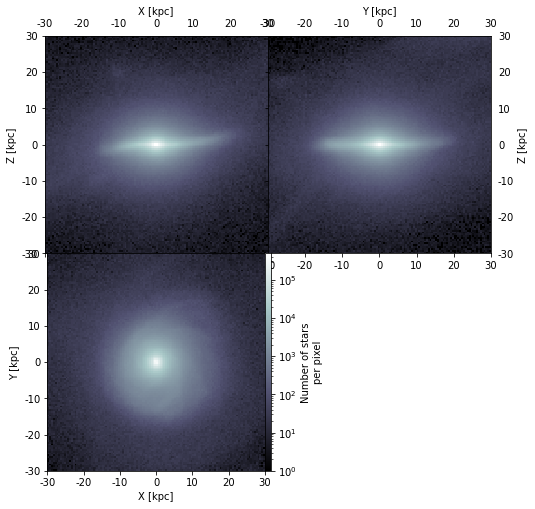

In [5]:
# array of positions in principal axes (in kpc)
pos_pa = part['star'].prop('host.distance.principal')

# preparing plot
bins = np.linspace(-kpc_aperture, kpc_aperture, int(np.ceil(2*kpc_aperture/kpc_pixel)+1))
fig = plt.figure(figsize=(20,8))
fig.subplots_adjust(wspace=0., hspace=0.)
_temp = np.array([2*[0],2*[1]])
_temp = np.dstack([_temp,_temp.T]).reshape((4,2))[:-1]
_temp = np.vstack([_temp, _temp+[0,3]])
axs = [plt.subplot2grid(shape=(2, 5), loc=loc, rowspan=1, colspan=1) for loc in _temp]
for ax in axs[1:]: ax.sharex(axs[0]), ax.sharey(axs[0])
axs[0].xaxis.set_tick_params(labeltop=True, labelbottom=False)
axs[1].xaxis.set_tick_params(labeltop=True, labelbottom=True)
axs[1].yaxis.set_tick_params(labelleft=False, labelright=True)
axs[0].xaxis.set_label_position('top')
axs[1].yaxis.set_label_position('right')
axs[1].xaxis.set_label_position('top')
axs[3].xaxis.set_tick_params(labeltop=True, labelbottom=False)
axs[4].xaxis.set_tick_params(labeltop=True, labelbottom=True)
axs[4].yaxis.set_tick_params(labelleft=False, labelright=True)
axs[3].xaxis.set_label_position('top')
axs[4].yaxis.set_label_position('right')
axs[4].xaxis.set_label_position('top')

# hide some axes for now
for ax in axs[3:]: ax.set_visible(False)

# plotting 2d histograms along each 3 principal axes
_,_,_,h2d = axs[0].hist2d(pos_pa[:,0], pos_pa[:,2], bins=[bins,bins], norm=LogNorm(), cmap=cmap)
vmin,vmax = h2d.get_clim()
_,_,_,h2d = axs[1].hist2d(pos_pa[:,1], pos_pa[:,2], bins=[bins,bins], norm=LogNorm(vmin=vmin, vmax=vmax), cmap=cmap)
_,_,_,h2d = axs[2].hist2d(pos_pa[:,0], pos_pa[:,1], bins=[bins,bins], norm=LogNorm(vmin=vmin, vmax=vmax), cmap=cmap)

# setting up all the labels
axs[2].set_xlabel('X [kpc]')
axs[2].set_ylabel('Y [kpc]')
axs[1].set_xlabel('Y [kpc]')
axs[1].set_ylabel('Z [kpc]')
axs[0].set_ylabel('Z [kpc]')
axs[0].set_xlabel('X [kpc]')

# detailing final subplots
axs[2].set_aspect(1.0/axs[2].get_data_ratio())
axs[0].set_facecolor(cmap(0))
axs[1].set_facecolor(cmap(0))
axs[2].set_facecolor(cmap(0))

# setting up the colorbar
ax0color_axis = axs[2].inset_axes([1, 0., 0.03, 1.], transform=axs[2].transAxes)
ax0cbar = fig.colorbar(h2d, cax=ax0color_axis)
ax0cbar.set_label('Number of stars\nper pixel')


Defining some other star particle data

In [6]:
# array of velocities in principal axes (in km/s)
vel_pa = part['star'].prop('host.velocity.principal')

# array of star particle mass in solar masses
mass = part['star']['mass']

# array of decimal log stellar ages (in Gyr)
log_age = np.log10(part['star'].prop('age') * 1e9)

# array of star particle metallicities
feh = part['star'].prop('metallicity.fe')

abundances_list = ['helium', 'carbon', 'nitrogen', 'oxygen', 'neon', 'magnesium', 'silicon', 'sulfur', 'calcium']
# dictionary of chemical abundance arrays (X/H)
abundances = {'sulphur' if el == 'sulfur' else el: part['star'].prop('metallicity.' + el) for el in abundances_list}

# alpha abundance (Mg/Fe)
alpha = abundances['magnesium'] - feh

Preparing the star particles data to be used by `ananke`, masking only a sphere within 30 kpc

In [7]:
mask = np.linalg.norm(pos_pa, axis=1)<=30

p = {}
p['pos3'] = pos_pa[mask]    # position in kpc (Nx3)
p['vel3'] = vel_pa[mask]    # velocity in km/s (Nx3)
p['mass'] = mass[mask]      # mass in solar masses
p['age'] = log_age[mask]    # log age in Gyr
p['feh'] = feh[mask]        # [Fe/H]
for el, abun in abundances.items():  
    p[el] = abun[mask]      # other abundances as [X/H]

p['alpha'] = alpha[mask]    # alpha abundance [Mg/Fe]

p['parentid'] = np.where(mask)[0]           # indices of parent particles in snapshot
p['dform'] = 0*p['mass']  # dummy variable for now

Now we can prepare the `ananke` surveyor. Default surveyor is set to simulate a Roman + HST photometric system.

In [8]:
surveyor = an.Ananke(p, name='anankethon', fsample=fsample, rSun0=0, rSun1=0, rSun2=0)

Let's make the surveyor survey!

In [9]:
survey = surveyor.run()

Dimensions = 3
Normalization constant of Kernel type 3: 0.596831
Reading ASCII format file: to_enbid 
Read 35417316 records
Allocated 450.354 MByte for particle storage.
Type = 1 Particles = 11805772
Total particles = 11805772
Allocated 2612.06 MByte for Binary-Tree and Entropy bins.

Scaling Co-ordinates as x[i]=x[i]/h[i] with h[i]->
1 1 1 

Starting to Build Tree .......
Particle Type = 1 First node number = 1
                  Last node number  = 23611543
Total number of nodes = 23611543
Treebuild time = 46.9063 s 

Density Calculation. Smoothing .....
Evaluated =   0 % Time Left = 528.020599 s of 533.354153 s Par no = 1357967 Density = 3.559928e+06 
Evaluated =   1 % Time Left = 517.176467 s of 527.731068 s Par no = 3385279 Density = 8.555834e+04 
Evaluated =   2 % Time Left = 514.503218 s of 530.415635 s Par no = 7907718 Density = 6.042684e+05 
Evaluated =   3 % Time Left = 511.376868 s of 532.684149 s Par no = 1445775 Density = 1.422839e+06 
Evaluated =   4 % Time Left = 505.4774

Evaluated =  77 % Time Left = 113.070078 s of 513.943987 s Par no = 2333388 Density = 9.118898e+04 
Evaluated =  78 % Time Left = 108.113247 s of 514.813383 s Par no = 11669072 Density = 7.910638e+04 
Evaluated =  79 % Time Left = 103.059197 s of 515.283634 s Par no = 1769676 Density = 2.623635e+01 
Evaluated =  80 % Time Left = 97.922101 s of 515.366311 s Par no = 7415357 Density = 1.682040e+04 
Evaluated =  81 % Time Left = 92.889378 s of 516.038007 s Par no = 1595471 Density = 1.248443e+06 
Evaluated =  82 % Time Left = 87.866520 s of 516.846747 s Par no = 3056090 Density = 1.814481e+04 
Evaluated =  83 % Time Left = 82.850944 s of 517.802096 s Par no = 5445194 Density = 3.566610e+05 
Evaluated =  84 % Time Left = 77.860848 s of 519.054674 s Par no = 1357138 Density = 3.081892e+06 
Evaluated =  85 % Time Left = 72.807056 s of 520.031232 s Par no = 10781915 Density = 9.725562e+04 
Evaluated =  86 % Time Left = 67.756535 s of 521.183184 s Par no = 9886753 Density = 2.507448e+04 
Evalu

Evaluated =  53 % Time Left = 286.182944 s of 622.132496 s Par no = 4611181 Density = 1.626204e-01 
Evaluated =  54 % Time Left = 279.985351 s of 622.185147 s Par no = 8745906 Density = 4.635810e-02 
Evaluated =  55 % Time Left = 273.561613 s of 621.726233 s Par no = 8893919 Density = 1.034242e-01 
Evaluated =  56 % Time Left = 267.198904 s of 621.387898 s Par no = 6601974 Density = 1.378397e-01 
Evaluated =  57 % Time Left = 260.748390 s of 620.824397 s Par no = 6109642 Density = 1.298262e-02 
Evaluated =  58 % Time Left = 254.633344 s of 621.051615 s Par no = 6623308 Density = 1.733138e-01 
Evaluated =  59 % Time Left = 248.343590 s of 620.853426 s Par no = 556672 Density = 4.886179e-03 
Evaluated =  60 % Time Left = 242.001629 s of 620.511214 s Par no = 9834138 Density = 4.610017e-03 
Evaluated =  61 % Time Left = 235.673154 s of 620.186477 s Par no = 6045172 Density = 7.255021e-02 
Evaluated =  62 % Time Left = 229.242587 s of 619.568267 s Par no = 4742037 Density = 1.039155e-01 
E

nbody1/anankethon/

	1	1

path nbody1/anankethon/ sats 1 x[0] 1


Using geometry:                     All Sky
setting center to 0 0 0 0 0 0
Reading Isochrones from dir-        /srv/conda/envs/notebook/.cache/Galaxia_ananke/GalaxiaData/Isochrones/padova/WFIRST-HST
Isochrone Grid Size:                (Age bins=177,Feh bins=34,Alpha bins=1)
Time Isochrone Reading              18.5038     
------------------------------
nbody1/anankethon/anankethon.ebf  Sat No=0
Particles=11805772
Satellite Info
Particles=11805772 Mass=7.09544e+10 0.379706
6607168 accepted  3392832 rejected Parts=303374 outof 303373
13243469 accepted  6756531 rejected Parts=601545 outof 601544
19788539 accepted  10211461 rejected Parts=917114 outof 917113
26393863 accepted  13606137 rejected Parts=1220207 outof 1220206
33074230 accepted  16925770 rejected Parts=1510031 outof 1510030
39638561 accepted  20361439 rejected Parts=1820098 outof 1820097
46244609 accepted  23755391 rejected Parts=2123201 outof 2123200
52928037 accepted  27071963 rejected Parts=2414470 outof 2414469
59401172 acce

Due to the large memory footprint potential of the survey data, the output object interfaces a `vaex` memory-mapped dataframe

In [10]:
survey

#,age,alpha,dec,dmod,feh,glat,glon,grav,lum,mact,mtip,parentid,partid,px,py,pz,ra,rad,smass,teff,vx,vy,vz,wfirst-hst_f110w,wfirst-hst_f160w,wfirst-hst_f184,wfirst-hst_f475w,wfirst-hst_f555w,wfirst-hst_f606w,wfirst-hst_f814w,wfirst-hst_h158,wfirst-hst_j129,wfirst-hst_w149,wfirst-hst_y106,wfirst-hst_z087
0,9.424542427062988,0.2324601709842682,-39.51919,14.638841491378656,0.11225732415914536,-0.9688518,257.87744,4.360697,0.22891429,1.1415478,1.5706087,7,0,-1.7779991626739502,-8.27774715423584,-0.14317993819713593,126.312996,8.467755279094392,1.1417601238302455,3.785519,165.9202117919922,-15.90091323852539,-24.24156951904297,4.065061,4.216096,4.447119,4.447885,4.219438,4.129473,3.9955316,4.239096,4.0840726,4.174578,4.0075436,4.028508
1,9.424542427062988,0.2324601709842682,-39.808956,14.632766567145179,0.11225732415914536,-1.9229922,257.5658,4.3879976,0.17091273,1.1153436,1.5706087,7,1,-1.8171405175319155,-8.241390589861714,-0.2833521297821646,125.06464,8.444098942135238,1.1155220009056497,3.7803743,166.74726636096932,-11.243874539922327,-29.838931618520387,4.1831284,4.324718,4.549872,4.614462,4.371846,4.2730775,4.1225386,4.3470774,4.200487,4.2892056,4.1322565,4.1626673
2,9.424542427062988,0.2324601709842682,-37.683235,14.603671184279001,0.11225732415914536,0.38396972,256.5865,4.481096,-0.056689512,1.0152473,1.5706087,7,1,-1.9327198275902575,-8.10425180887652,0.055834828846463375,126.76697,8.331711759401616,1.0153815490665536,3.7569468,167.39349806380005,-18.50950666099722,-22.060734837234946,4.654936,4.743335,4.948916,5.287576,4.9939747,4.8613195,4.6450095,4.7630982,4.6624627,4.7399898,4.6350636,4.715665
3,9.424542427062988,0.2324601709842682,-39.636185,14.641409540038765,0.11225732415914536,-0.8886136,258.07773,3.929362,0.8050556,1.463446,1.5706087,7,1,-1.751159479014375,-8.29390318569981,-0.13147847080139688,126.54819,8.477775425368828,1.4638591859596224,3.7947576,165.91811761338968,-16.510709820764927,-30.100891521445384,2.671678,2.8453283,3.0846534,2.9597523,2.7608442,2.6880527,2.587028,2.86877,2.6955614,2.7905614,2.6039114,2.6072612
4,9.424542427062988,0.2324601709842682,-39.032345,14.628023970231641,0.11225732415914536,-1.044659,257.22916,4.505591,-0.12821849,0.98460335,1.5706087,7,1,-1.8621998494379022,-8.215877504227914,-0.15361459522498386,125.75158,8.425676761399702,0.9847472491186235,3.7485633,163.2508134695004,-17.62928611228657,-23.75366627397435,4.8023295,4.872079,5.0691366,5.507177,5.196503,5.0521955,4.8125796,4.891079,4.8067527,4.880387,4.795637,4.8933105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"249,269,158",10.04150390625,0.3492337465286255,-14.526683,16.437467070925077,-1.5451802015304565,23.618309,0.8158228,4.337699,0.16246688,0.7676151,0.8277561,13974703,1,17.760540417754846,0.2529056633174072,7.766933021407683,246.14787,19.386232376722266,0.7682862696197156,3.806243,-188.76911710760282,-152.75411116490105,-72.57500100109218,4.4197073,4.5728703,4.815258,4.6276364,4.489606,4.4331875,4.3387384,4.5988703,4.4419017,4.531095,4.353126,4.366963
"249,269,159",10.04150390625,0.3492337465286255,-13.685813,16.60592985267219,-1.5451802015304565,24.314678,1.3840092,3.7603881,0.65944576,0.8153858,0.8277561,13974703,1,19.086206226989653,0.46112671038259456,8.626153356877888,245.92331,20.95009374009058,0.8168005804976556,3.7796276,-195.11525475949676,-151.57050308574856,-66.56192429942504,3.0510037,3.1629066,3.3838744,3.4403927,3.262502,3.17785,3.0163076,3.1879067,3.0655909,3.1459713,3.0128622,3.0773723
"249,269,160",10.04150390625,0.3492337465286255,-16.445028,16.579679501493004,-1.5451802015304565,22.747179,358.895,4.0165634,0.5171913,0.80755687,0.8277561,13974703,1,19.084891442555726,-0.3681224777792652,8.003339320673764,245.68666,20.698358287908388,0.8087602382099166,3.8091178,-196.28250650063873,-149.0638768574198,-74.9202188884697,3.5432014,3.70571,3.9499643,3.718168,3.5895493,3.5388036,3.456566,3.731837,3.5663285,3.65

In [11]:
type(survey)

Galaxia_ananke.Output.Output

Currently, accessing the underlying `vaex` dataframe can be done directly via the following property (planning to improve that in the future)

In [12]:
survey._vaex

#,age,alpha,dec,dmod,feh,glat,glon,grav,lum,mact,mtip,parentid,partid,px,py,pz,ra,rad,smass,teff,vx,vy,vz,wfirst-hst_f110w,wfirst-hst_f160w,wfirst-hst_f184,wfirst-hst_f475w,wfirst-hst_f555w,wfirst-hst_f606w,wfirst-hst_f814w,wfirst-hst_h158,wfirst-hst_j129,wfirst-hst_w149,wfirst-hst_y106,wfirst-hst_z087
0,9.424542427062988,0.2324601709842682,-39.51919,14.638841491378656,0.11225732415914536,-0.9688518,257.87744,4.360697,0.22891429,1.1415478,1.5706087,7,0,-1.7779991626739502,-8.27774715423584,-0.14317993819713593,126.312996,8.467755279094392,1.1417601238302455,3.785519,165.9202117919922,-15.90091323852539,-24.24156951904297,4.065061,4.216096,4.447119,4.447885,4.219438,4.129473,3.9955316,4.239096,4.0840726,4.174578,4.0075436,4.028508
1,9.424542427062988,0.2324601709842682,-39.808956,14.632766567145179,0.11225732415914536,-1.9229922,257.5658,4.3879976,0.17091273,1.1153436,1.5706087,7,1,-1.8171405175319155,-8.241390589861714,-0.2833521297821646,125.06464,8.444098942135238,1.1155220009056497,3.7803743,166.74726636096932,-11.243874539922327,-29.838931618520387,4.1831284,4.324718,4.549872,4.614462,4.371846,4.2730775,4.1225386,4.3470774,4.200487,4.2892056,4.1322565,4.1626673
2,9.424542427062988,0.2324601709842682,-37.683235,14.603671184279001,0.11225732415914536,0.38396972,256.5865,4.481096,-0.056689512,1.0152473,1.5706087,7,1,-1.9327198275902575,-8.10425180887652,0.055834828846463375,126.76697,8.331711759401616,1.0153815490665536,3.7569468,167.39349806380005,-18.50950666099722,-22.060734837234946,4.654936,4.743335,4.948916,5.287576,4.9939747,4.8613195,4.6450095,4.7630982,4.6624627,4.7399898,4.6350636,4.715665
3,9.424542427062988,0.2324601709842682,-39.636185,14.641409540038765,0.11225732415914536,-0.8886136,258.07773,3.929362,0.8050556,1.463446,1.5706087,7,1,-1.751159479014375,-8.29390318569981,-0.13147847080139688,126.54819,8.477775425368828,1.4638591859596224,3.7947576,165.91811761338968,-16.510709820764927,-30.100891521445384,2.671678,2.8453283,3.0846534,2.9597523,2.7608442,2.6880527,2.587028,2.86877,2.6955614,2.7905614,2.6039114,2.6072612
4,9.424542427062988,0.2324601709842682,-39.032345,14.628023970231641,0.11225732415914536,-1.044659,257.22916,4.505591,-0.12821849,0.98460335,1.5706087,7,1,-1.8621998494379022,-8.215877504227914,-0.15361459522498386,125.75158,8.425676761399702,0.9847472491186235,3.7485633,163.2508134695004,-17.62928611228657,-23.75366627397435,4.8023295,4.872079,5.0691366,5.507177,5.196503,5.0521955,4.8125796,4.891079,4.8067527,4.880387,4.795637,4.8933105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"249,269,158",10.04150390625,0.3492337465286255,-14.526683,16.437467070925077,-1.5451802015304565,23.618309,0.8158228,4.337699,0.16246688,0.7676151,0.8277561,13974703,1,17.760540417754846,0.2529056633174072,7.766933021407683,246.14787,19.386232376722266,0.7682862696197156,3.806243,-188.76911710760282,-152.75411116490105,-72.57500100109218,4.4197073,4.5728703,4.815258,4.6276364,4.489606,4.4331875,4.3387384,4.5988703,4.4419017,4.531095,4.353126,4.366963
"249,269,159",10.04150390625,0.3492337465286255,-13.685813,16.60592985267219,-1.5451802015304565,24.314678,1.3840092,3.7603881,0.65944576,0.8153858,0.8277561,13974703,1,19.086206226989653,0.46112671038259456,8.626153356877888,245.92331,20.95009374009058,0.8168005804976556,3.7796276,-195.11525475949676,-151.57050308574856,-66.56192429942504,3.0510037,3.1629066,3.3838744,3.4403927,3.262502,3.17785,3.0163076,3.1879067,3.0655909,3.1459713,3.0128622,3.0773723
"249,269,160",10.04150390625,0.3492337465286255,-16.445028,16.579679501493004,-1.5451802015304565,22.747179,358.895,4.0165634,0.5171913,0.80755687,0.8277561,13974703,1,19.084891442555726,-0.3681224777792652,8.003339320673764,245.68666,20.698358287908388,0.8087602382099166,3.8091178,-196.28250650063873,-149.0638768574198,-74.9202188884697,3.5432014,3.70571,3.9499643,3.718168,3.5895493,3.5388036,3.456566,3.731837,3.5663285,3.65

In [13]:
type(survey._vaex)

vaex.dataframe.DataFrameLocal

That said, some operations are directly accessible from the output object

In [14]:
survey[['px','py','pz']]

#,px,py,pz
0,-1.7779991626739502,-8.27774715423584,-0.14317993819713593
1,-1.8171405175319155,-8.241390589861714,-0.2833521297821646
2,-1.9327198275902575,-8.10425180887652,0.055834828846463375
3,-1.751159479014375,-8.29390318569981,-0.13147847080139688
4,-1.8621998494379022,-8.215877504227914,-0.15361459522498386
...,...,...,...
"249,269,158",17.760540417754846,0.2529056633174072,7.766933021407683
"249,269,159",19.086206226989653,0.46112671038259456,8.626153356877888
"249,269,160",19.084891442555726,-0.3681224777792652,8.003339320673764
"249,269,161",19.496178394288954,1.3709767671054252,7.144537813796613


In [15]:
survey.teff

Expression = teff
Length: 249,269,163 dtype: float32 (column)
-------------------------------------------
        0  3.78552
        1  3.78037
        2  3.75695
        3  3.79476
        4  3.74856
       ...        
249269158  3.80624
249269159  3.77963
249269160  3.80912
249269161   3.7869
249269162  3.81411

To access the mock catalog bands for the chosen photometric system, they are selectable with the following string key syntax `f"{name_of_photometric_system}_{name_of_band}"` (that syntax might change in the future to `f"{name_of_photometric_system}/{name_of_band}"`, I'll raise a `DeprecationWarning` for a few version when that's effectively planned)

In [16]:
survey['wfirst-hst_f814w']

Expression = df['wfirst-hst_f814w']
Length: 249,269,163 dtype: float32 (expression)
-----------------------------------------------
        0  3.99553
        1  4.12254
        2  4.64501
        3  2.58703
        4  4.81258
       ...        
249269158  4.33874
249269159  3.01631
249269160  3.45657
249269161   4.9485
249269162  3.84306

In [17]:
survey['wfirst-hst_h158']

Expression = df['wfirst-hst_h158']
Length: 249,269,163 dtype: float32 (expression)
-----------------------------------------------
        0   4.2391
        1  4.34708
        2   4.7631
        3  2.86877
        4  4.89108
       ...        
249269158  4.59887
249269159  3.18791
249269160  3.73184
249269161  5.14709
249269162  4.13661

In [18]:
survey[['wfirst-hst_z087','wfirst-hst_y106','wfirst-hst_j129','wfirst-hst_w149','wfirst-hst_h158','wfirst-hst_f184']]

#,wfirst-hst_z087,wfirst-hst_y106,wfirst-hst_j129,wfirst-hst_w149,wfirst-hst_h158,wfirst-hst_f184
0,4.028508,4.0075436,4.0840726,4.174578,4.239096,4.447119
1,4.1626673,4.1322565,4.200487,4.2892056,4.3470774,4.549872
2,4.715665,4.6350636,4.6624627,4.7399898,4.7630982,4.948916
3,2.6072612,2.6039114,2.6955614,2.7905614,2.86877,3.0846534
4,4.8933105,4.795637,4.8067527,4.880387,4.891079,5.0691366
...,...,...,...,...,...,...
"249,269,158",4.366963,4.353126,4.4419017,4.531095,4.5988703,4.815258
"249,269,159",3.0773723,3.0128622,3.0655909,3.1459713,3.1879067,3.3838744
"249,269,160",3.4781847,3.4728203,3.5663285,3.6574557,3.731837,3.9499643
"249,269,161",5.00355,4.9499817,5.014618,5.0967765,5.1470947,5.348731


Let's have a look at the population of synthetic star we created

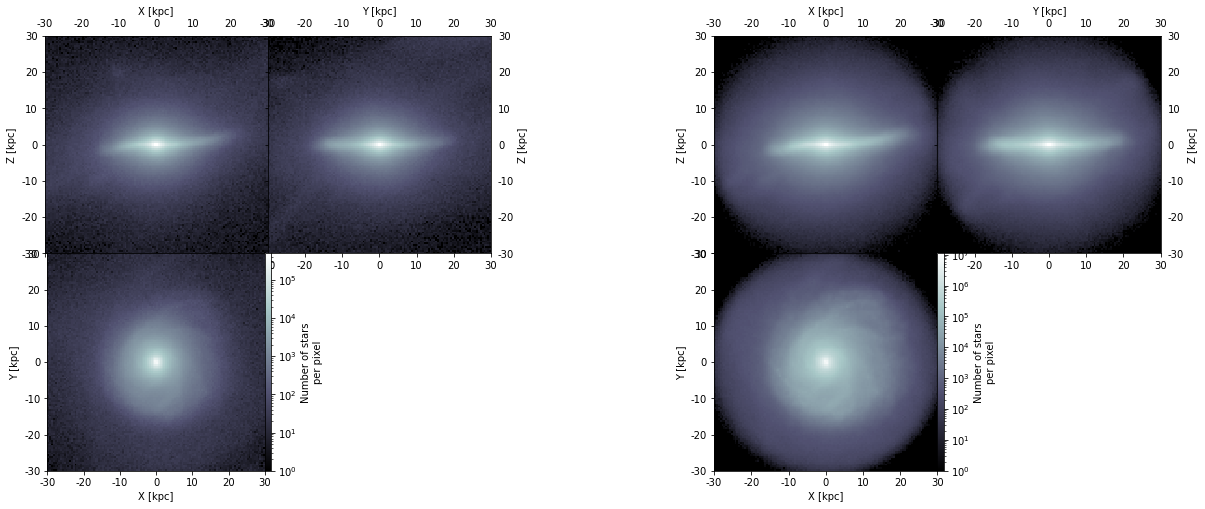

In [19]:
# show axes that were hidden before 
for ax in axs[3:]: ax.set_visible(True)

# converting vaex sub-dataframe to numpy
mock_pos = survey[['px','py','pz']].to_pandas_df().to_numpy()

# plotting 2d histograms along each 3 principal axes
_,_,_,h2d = axs[3].hist2d(mock_pos[:,0], mock_pos[:,2], bins=[bins,bins], norm=LogNorm(), cmap=cmap)
vmin,vmax = h2d.get_clim()
_,_,_,h2d = axs[4].hist2d(mock_pos[:,1], mock_pos[:,2], bins=[bins,bins], norm=LogNorm(vmin=vmin, vmax=vmax), cmap=cmap)
_,_,_,h2d = axs[5].hist2d(mock_pos[:,0], mock_pos[:,1], bins=[bins,bins], norm=LogNorm(vmin=vmin, vmax=vmax), cmap=cmap)

# setting up all the labels
axs[5].set_xlabel('X [kpc]')
axs[5].set_ylabel('Y [kpc]')
axs[4].set_xlabel('Y [kpc]')
axs[4].set_ylabel('Z [kpc]')
axs[3].set_ylabel('Z [kpc]')
axs[3].set_xlabel('X [kpc]')

# detailing final subplots
axs[3].set_facecolor(cmap(0))
axs[4].set_facecolor(cmap(0))
axs[5].set_facecolor(cmap(0))

# setting up the colorbar
ax0color_axis = axs[5].inset_axes([1, 0., 0.03, 1.], transform=axs[5].transAxes)
ax0cbar = fig.colorbar(h2d, cax=ax0color_axis)
ax0cbar.set_label('Number of stars\nper pixel')

fig

While this is showing here the mock stars in their 3D coordinates, `ananke` also returns celestial coordinates

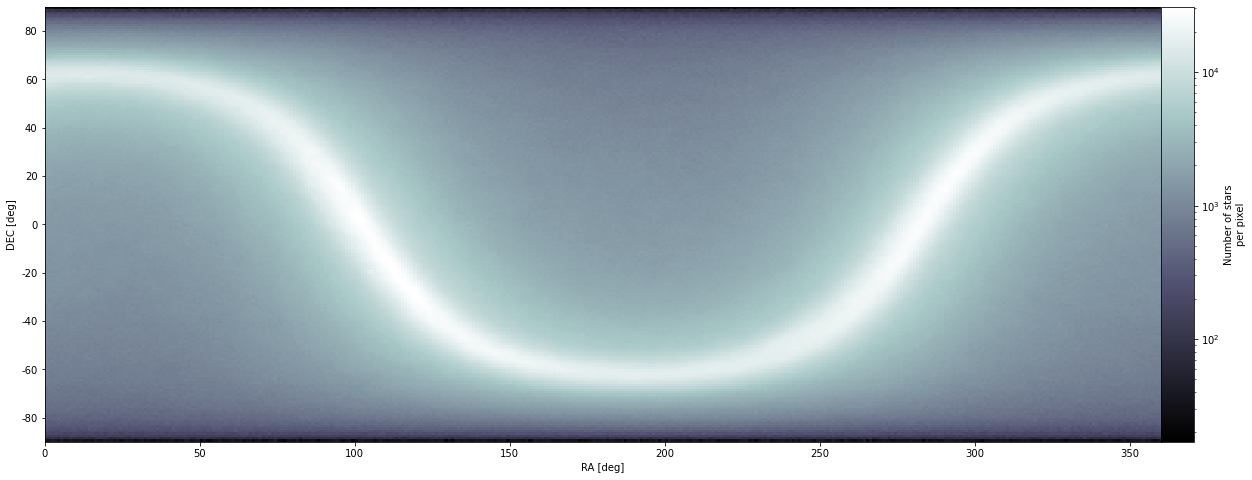

In [20]:
ra_deg = survey.ra.to_numpy()
dec_deg = survey.dec.to_numpy()

fig2 = plt.figure(figsize=(20,8))
ax = fig2.add_subplot(111)

_,_,_,h2d = ax.hist2d(ra_deg, dec_deg, bins=[np.linspace(0,360,int(np.ceil(361/sky_pix_deg))),
                                             np.linspace(-90,90,int(np.ceil(181/sky_pix_deg)))],
                                       norm=LogNorm(), cmap=cmap)

# setting up all the labels
ax.set_xlabel('RA [deg]')
ax.set_ylabel('DEC [deg]')

# detailing final subplots
ax.set_facecolor(cmap(0))

# setting up the colorbar
ax0color_axis = ax.inset_axes([1, 0., 0.03, 1.], transform=ax.transAxes)
ax0cbar = fig.colorbar(h2d, cax=ax0color_axis)
ax0cbar.set_label('Number of stars\nper pixel')

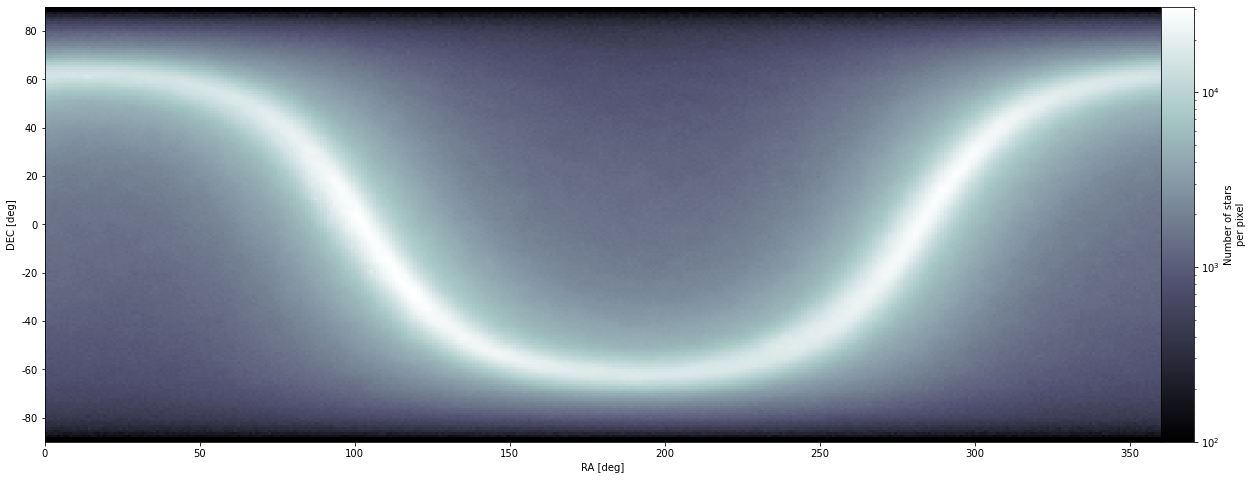

In [21]:
h2d.set_clim((100,h2d.get_clim()[1]))
fig2

Let's also have a look at some hertzsprung russell/color magnitude diagrams

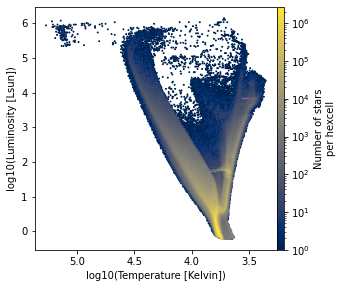

In [22]:
luminosity = survey.lum.to_numpy()
temperature = survey.teff.to_numpy()

fig3,axs=plt.subplots(nrows=1,ncols=3,figsize=(20,8), subplot_kw={'adjustable':'box'})
fig3.subplots_adjust(wspace=0.8)
for ax in axs[1:]: ax.set_visible(False)

hb = axs[0].hexbin(temperature, luminosity, gridsize=(241),
                   bins='log', cmap=hex_cmap)

axs[0].invert_xaxis()
axs[0].set_xlabel('log10(Temperature [Kelvin])')
axs[0].set_ylabel('log10(Luminosity [Lsun])')
axs[0].set_aspect(1.0/axs[0].get_data_ratio())

ax0color_axis = axs[0].inset_axes([1, 0., 0.03, 1.], transform=axs[0].transAxes)

ax0cbar = fig.colorbar(hb, cax=ax0color_axis, location='right')
ax0cbar.set_label('Number of stars\nper hexcell')


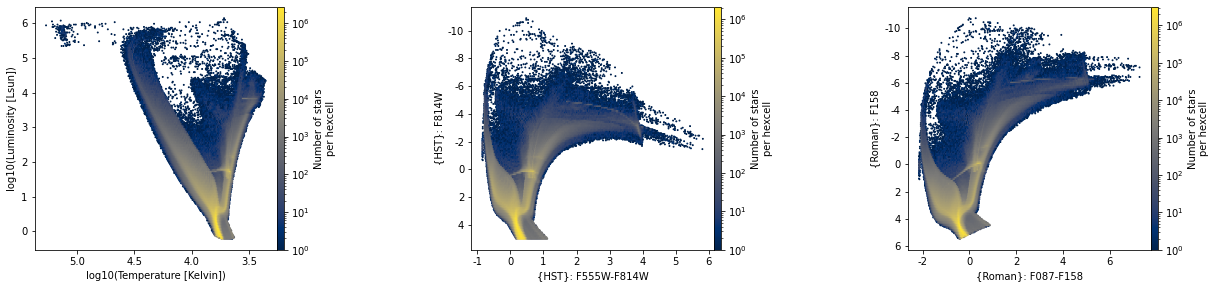

In [23]:
for ax in axs[1:]: ax.set_visible(True)

mag_cmd1 = survey['wfirst-hst_f814w'].to_numpy()
color_cmd1 = survey['wfirst-hst_f555w'].to_numpy() - mag_cmd1

hb = axs[1].hexbin(color_cmd1, mag_cmd1, gridsize=(241),
                   bins='log', cmap=hex_cmap)

axs[1].invert_yaxis()
axs[1].set_xlabel('{HST}: F555W-F814W')
axs[1].set_ylabel('{HST}: F814W')
axs[1].set_aspect(1.0/axs[1].get_data_ratio())

ax1color_axis = axs[1].inset_axes([1, 0., 0.03, 1.], transform=axs[1].transAxes)

ax1cbar = fig.colorbar(hb, cax=ax1color_axis, location='right')
ax1cbar.set_label('Number of stars\nper hexcell')


mag_cmd2 = survey['wfirst-hst_f184'].to_numpy()
color_cmd2 = survey['wfirst-hst_z087'].to_numpy() - mag_cmd2

hb = axs[2].hexbin(color_cmd2, mag_cmd2, gridsize=(241),
                   bins='log', cmap=hex_cmap)

axs[2].invert_yaxis()
axs[2].set_xlabel('{Roman}: F087-F158')
axs[2].set_ylabel('{Roman}: F158')
axs[2].set_aspect(1.0/axs[2].get_data_ratio())

ax2color_axis = axs[2].inset_axes([1, 0., 0.03, 1.], transform=axs[2].transAxes)

ax2cbar = fig.colorbar(hb, cax=ax2color_axis, location='right')
ax2cbar.set_label('Number of stars\nper hexcell')

fig3


This photometric system isn't the only one natively built in `py-ananke`, there a couple of others although just a couple. We plan to add more in the future, this is work in progress for now. This command will return which can be used:

In [24]:
# for now, it is necessary to import Galaxia's submodule
import Galaxia_ananke

Galaxia_ananke.photometry.available_photo_systems

{'padova': {'DCMC': Isochrone(category=padova, name=DCMC),
  'GAIA': Isochrone(category=padova, name=GAIA),
  'GAIA-TYCHO-2MASS': Isochrone(category=padova, name=GAIA-TYCHO-2MASS),
  'GAIADR2': Isochrone(category=padova, name=GAIADR2),
  'LSST': Isochrone(category=padova, name=LSST),
  'SDSS': Isochrone(category=padova, name=SDSS),
  'STROEMGREN': Isochrone(category=padova, name=STROEMGREN),
  'UBV': Isochrone(category=padova, name=UBV),
  'WFIRST': Isochrone(category=padova, name=WFIRST),
  'WFIRST-HST': Isochrone(category=padova, name=WFIRST-HST),
  'WFIRST-LSST': Isochrone(category=padova, name=WFIRST-LSST)},
 'py_custom': {}}

That said, if you wish to add your own photometric system, this is currently possible but we hope to improve the API

In [25]:
iso = Galaxia_ananke.photometry.available_photo_systems['padova/WFIRST-HST']

isochrone_data = {i_file.metallicity: i_file.data.to_pandas()[
    ['log(age/yr)', 'M_ini', 'M_act', 'logL/Lo', 'logTe', 'logG', 'Z087', 'Y106', 'J129', 'H158', 'F184', 'W149', 'F475W', 'F555W', 'F606W', 'F814W', 'F110W', 'F160W']
    ].rename(columns=dict(zip(['log(age/yr)', 'M_ini', 'M_act', 'logL/Lo', 'logTe', 'logG'],['Age','M_ini', 'M_act', 'Lum', 'T_eff', 'Grav'])))
    for i_file in iso.isochrone_files}


In [26]:
np.array(list(isochrone_data.keys()))

array([0.0001, 0.0002, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009,
       0.001 , 0.0012, 0.0014, 0.0016, 0.0018, 0.002 , 0.0022, 0.0024,
       0.0026, 0.0028, 0.003 , 0.0034, 0.004 , 0.005 , 0.006 , 0.007 ,
       0.008 , 0.009 , 0.01  , 0.012 , 0.014 , 0.016 , 0.018 , 0.02  ,
       0.024 , 0.026 , 0.028 , 0.03  ])

In [27]:
isochrone_data[0.008]

,Age,M_ini,M_act,Lum,T_eff,Grav,Z087,Y106,J129,H158,F184,W149,F475W,F555W,F606W,F814W,F110W,F160W
0,6.60,0.090000,0.0900,-1.5393,3.4425,3.6534,10.285,8.290,7.566,7.525,7.569,7.683,12.824,12.228,11.580,9.005,7.676,7.540
1,6.60,0.093790,0.0938,-1.5324,3.4435,3.6687,10.252,8.269,7.550,7.508,7.553,7.666,12.783,12.186,11.541,8.978,7.660,7.522
2,6.60,0.105376,0.1054,-1.5049,3.4474,3.7072,10.127,8.188,7.486,7.441,7.489,7.598,12.628,12.027,11.394,8.875,7.593,7.454
3,6.60,0.110705,0.1107,-1.4878,3.4494,3.7194,10.055,8.139,7.445,7.399,7.448,7.556,12.538,11.937,11.310,8.815,7.551,7.411
4,6.60,0.114959,0.1150,-1.4798,3.4504,3.7319,10.020,8.115,7.426,7.379,7.430,7.536,12.495,11.893,11.269,8.786,7.532,7.391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87756,10.12,0.904188,0.5571,3.5576,3.5683,-0.1484,-3.656,-4.443,-4.879,-5.219,-5.272,-4.982,-1.748,-2.602,-3.068,-4.178,-4.797,-5.203
87757,10.12,0.904188,0.5551,3.5556,3.5708,-0.1380,-3.683,-4.442,-4.871,-5.203,-5.253,-4.969,-1.786,-2.641,-3.114,-4.183,-4.790,-5.187
87758,10.12,0.904188,0.5531,3.5536,3.5733,-0.1276,-3.704,-4.441,-4.864,-5.187,-5.233,-4.957,-1.821,-2.674,-3.150,-4.186,-4.783,-5.171
87759,10.12,0.904188,0.5512,3.5517,3.5758,-0.1173,-3.725,-4.440,-4.857,-5.171,-5.214,-4.945,-1.856,-2.707,-3.184,-4.190,-4.777,-5.156


In [28]:
# Galaxia_ananke.photometry.available_photo_systems.add_isochrone('Test', isochrone_data)

# new_iso = Galaxia_ananke.photometry.available_photo_systems['py_custom/Test']